**21-03-30 자연어처리 05_RNN 이용한 창작(작곡) (c)cherryuki (ji)**

# ch05. RNN 이용한 창작(작곡)
## 0. 코딩 준비
- 참조 document : https://web.mit.edu/music21/doc/index.html
- 참조 예제 : https://bit.ly/2HQ9Q4J
- 참조 데이터 : https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
- 악보 처리용 프로그램 추가 :https://musescore.org (MuseScore3인스톨)
- 악보를 보기 위한 setting : us=music21.environment.UserSettings() us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
- pip install music21

In [1]:
import numpy as np
import music21
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import os

## 1. 데이터 준비하기
### 시퀀스 데이터 정의

In [2]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
print("length of seq:{0}".format(len(seq)))

length of seq:54


In [3]:
note_seq = " ".join(seq)
note_seq

'g8 e8 e4 f8 d8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4'

In [4]:
#음악 재생해보기
m = music21.converter.parse("2/4"+note_seq, format='tinyNotation')
m.show('midi')

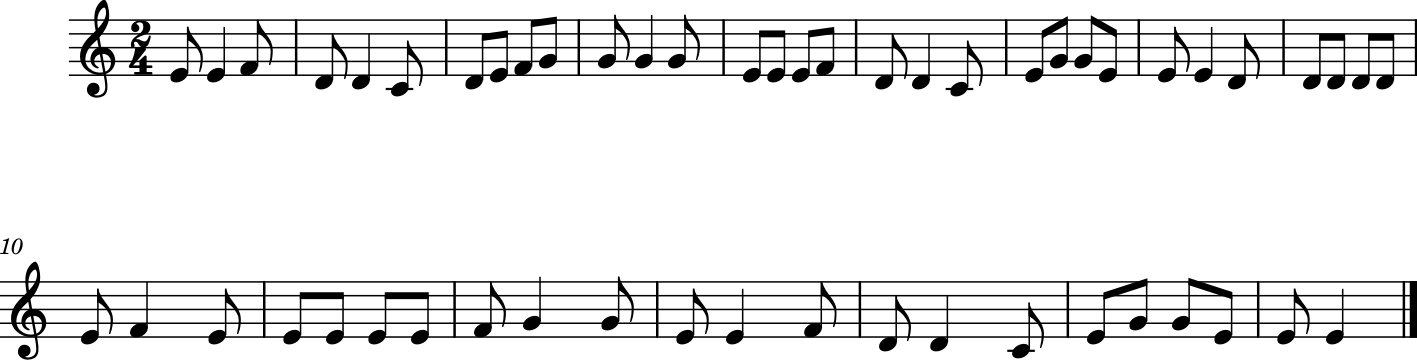

In [6]:
#악보 처리용 프로그램 추가 :https://musescore.org 
us=music21.environment.UserSettings() 
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
m.show()

### 코드 사전 정의

In [7]:
note_seq

'g8 e8 e4 f8 d8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4'

In [8]:
#Tokinizer + texts_to_sequences를 사용하면 자동으로 번호가 부여되므로 원하는 인덱스로 만들기 위함

code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}
idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

## 2. 데이터셋 생성
### 데이터셋 생성함수

In [9]:
code2idx['a4']

5

In [10]:
print([code2idx[item] for item in seq])

[11, 9, 2, 10, 8, 1, 7, 8, 9, 10, 11, 11, 4, 11, 9, 9, 9, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2, 8, 8, 8, 8, 8, 9, 3, 9, 9, 9, 9, 9, 10, 4, 11, 9, 2, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2]


In [11]:
#seq를 학습시킬 데이터 셋으로 반환하는 함수
#seq = 음계가 담긴 리스트, window_size: 독립변수의 개수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        encoded = [code2idx[item] for item in subset]
        dataset.append(encoded)
    return np.array(dataset)

In [12]:
print(seq[0:10])
print(seq2dataset(seq=seq[0:10], window_size=4))

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8']
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]]


### 생성

In [13]:
n_steps = 4 #4개씩 학습(독립변수 개수)
n_inputs = 1
dataset = seq2dataset(seq=seq, window_size=n_steps)
print(dataset[:2])
print(dataset.shape)

[[11  9  2 10  8]
 [ 9  2 10  8  1]]
(50, 5)


### 독립변수(X), 종속변수(Y) 분리

In [15]:
x_train = dataset[:, :-1]
y_train = dataset[:, -1]
print(dataset[0])
print(x_train[0], y_train[0])
print(x_train.shape, y_train.shape)

[11  9  2 10  8]
[11  9  2 10] 8
(50, 4) (50,)


In [16]:
#정규화 시킬 때 나눌 값: code2idx의 제일 큰 값 values
max_idx_value = max(code2idx.values())
max_idx_value

13

### 독립변수 정규화

In [17]:
print('정규화 전 x_train[:2]', x_train[:2], sep='\n')
x_train = x_train / float(max_idx_value)
print('정규화 후 x_train[:2]', x_train[:2], sep='\n')

정규화 전 x_train[:2]
[[11  9  2 10]
 [ 9  2 10  8]]
정규화 후 x_train[:2]
[[0.84615385 0.69230769 0.15384615 0.76923077]
 [0.69230769 0.15384615 0.76923077 0.61538462]]


### 독립변수의 shape 변환(샘플수, nsteps -> 샘플수, nsteps, 1)

In [18]:
x_train.shape

(50, 4)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_inputs))
x_train.shape

(50, 4, 1)

### 종속변수(라벨값) 원핫 인코딩

In [20]:
y_train

array([ 8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,  7,
        9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,  9,
        9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

In [21]:
y_train = utils.to_categorical(y_train)
y_train

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [22]:
one_hot_vec_size=y_train.shape[1]
one_hot_vec_size

12

## 3. 모델 구성하기

In [23]:
model = Sequential()
model.add(LSTM(units=128,
              kernel_initializer='glorot_normal',
              bias_initializer='zero',
              batch_input_shape=(1, n_steps, n_inputs),
              stateful=True))
model.add(Dense(units=one_hot_vec_size,
               kernel_initializer='glorot_normal',
               bias_initializer='zero',
               activation='softmax'))

## 4. 모델 학습과정 설정하기

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 5. 모델 학습시키기
### 손실이력 클래스 정의

In [26]:
import tensorflow as tf
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f}, accuracy : {2:8.6f}".\
                  format(self.epoch, logs.get('loss'), logs.get('accuracy')))
        self.epoch += 1

### 학습

In [27]:
num_epochs = 1500
history = LossHistory()  # 손실 이력 객체 생성

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history])
    if history.losses[-1] < 1e-5:
        print("epoch: {0} - loss: {1:8.6f}".format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break
    model.reset_states()

epoch: 0 - loss: 2.396762, accuracy : 0.300000
epoch: 100 - loss: 1.338494, accuracy : 0.440000
epoch: 200 - loss: 0.004911, accuracy : 1.000000
epoch: 300 - loss: 0.852416, accuracy : 0.680000
epoch: 400 - loss: 0.001971, accuracy : 1.000000
epoch: 500 - loss: 0.000112, accuracy : 1.000000
epoch: 590 - loss: 0.000010


In [28]:
print("{:.5f}".format(1e-5))

0.00001


## 6. 학습과정 살펴보기

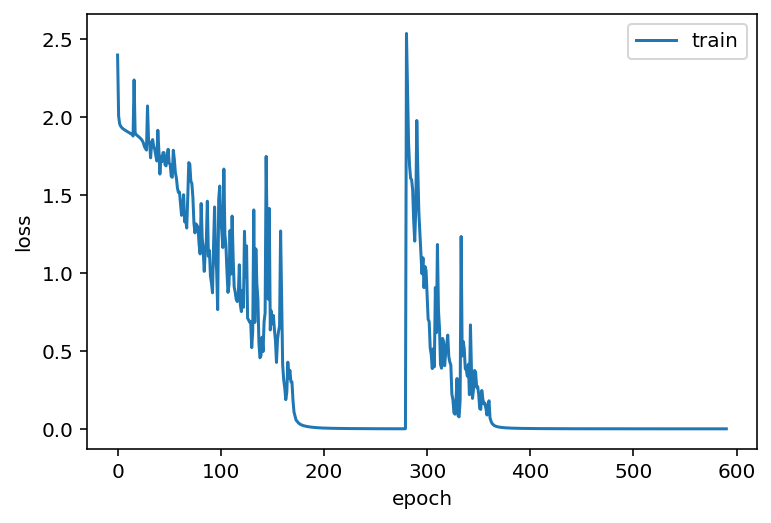

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## 7. 모델 평가하기

In [30]:
model.evaluate(x_train, y_train, batch_size=1)
model.reset_states()

50/50 [==============================] - 0s 918us/step - loss: 9.5247e-06 - accuracy: 1.0000


## 8. 모델 사용하기
### 한 스텝 예측

In [31]:
x_train[0]
temp = x_train[0].reshape(1,4,1)
temp

array([[[0.84615385],
        [0.69230769],
        [0.15384615],
        [0.76923077]]])

In [32]:
idx = np.argmax(model.predict(temp))
idx

8

In [33]:
idx2code[idx]

'd8'

### 곡 전체 예측

In [35]:
pred_count = 50 #최대 예측 개수
seq_in = ['g8', 'c8', 'f4', 'e8']
seq_out = seq_in
seq_in = [code2idx[note]/float(max_idx_value) for note in seq_in] #코드를 인덱스 값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, n_steps, n_inputs)) #샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)
model.reset_states()
print("full song prediction")
for note in seq_out:
    print(note, end=' ')

full song prediction
g8 c8 f4 e8 c8 d4 c8 d8 g8 g8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 

In [36]:
print(seq_out)

['g8', 'c8', 'f4', 'e8', 'c8', 'd4', 'c8', 'd8', 'g8', 'g8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [37]:
#나비야 초반 : 'g8', 'e8', 'e4', 'f8'
note_seq = ""
for note in seq_out:
    note_seq += note+" "

conv_midi = music21.converter.subConverters.ConverterMidi()
m = music21.converter.parse("2/4" + note_seq, format='tinyNotation')
m.show('midi')